## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "multilevel_elasticities_single_sku"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
market_df = pd.read_csv("../data/multilevel_elasticities_single_sku_data.csv")

In [4]:
region_id_out = 8

market_red_df = market_df.query("region_id != @region_id_out")
market_out_df = market_df.query("region_id == @region_id_out")

In [5]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = market_df["log_price"].to_numpy()
quantities = market_df["quantities"].to_numpy()
log_quantities = market_df["log_quantities"].to_numpy()
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

In [6]:
obs_red = market_red_df.index.to_numpy()
price_red = market_red_df["price"].to_numpy()
log_price_red = market_red_df["log_price"].to_numpy()
quantities_red = market_red_df["quantities"].to_numpy()
log_quantities_red = market_red_df["log_quantities"].to_numpy()
median_income_idx_red, median_income_red = market_red_df["median_income"].factorize(
    sort=True
)
region_idx_red, region_red = market_red_df["region_id"].factorize(sort=True)

https://tomicapretto.github.io/posts/2022-06-12_lkj-prior/#hierarchical-modeling-with-the-lkj-prior-in-pymc

In [7]:
# coords = {
#     "region": region,
#     "obs": obs,
#     "effect": ["intercept", "slope"],
# }

# J = 2

# with pm.Model(coords=coords) as model_cov:
#     # --- Priors ---
#     alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
#     beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

#     # Residual SD
#     sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

#     ## ---  Begin of rstanarm approach
#     tau = pm.Gamma(name="tau", alpha=1, beta=1)
#     xi = J * tau**2
#     pi = pm.Dirichlet(name="pi", a=np.ones(J), dims="effect")
#     sigma_val = pm.Deterministic(name="b", var=sigma * pi * (xi**0.5))
#     # --  End of rstanarm approach

#     # Construct diagonal matrix of standard deviations
#     sigmas = pm.Deterministic(name="diagonal", var=pt.eye(2) * sigma_val)
#     # Triangular upper part of the correlation matrix
#     corr_triu = pm.LKJCorr(name="corr_triu", eta=2, n=2, dims="effect")
#     # Correlation matrix
#     corr = pm.Deterministic(
#         name="corr",
#         var=pt.fill_diagonal(corr_triu[np.zeros((2, 2), dtype=np.int64)], 1.0),
#     )
#     # Covariance matrix
#     cov = pt.nlinalg.matrix_dot(sigmas, corr, sigmas)
#     # Cholesky decomposition, lower triangular matrix
#     chol = pm.Deterministic(name="chol", var=pt.slinalg.cholesky(cov))

#     z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
#     slopes = pm.Deterministic(
#         name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
#     )

#     # --- Parametrization ---
#     alpha_j_slope = pm.Deterministic(
#         name="alpha_j_slope", var=slopes[:, 0], dims="region"
#     )

#     beta_j_slope = pm.Deterministic(
#         name="beta_j_slope", var=slopes[:, 1], dims="region"
#     )

#     alpha_j = pm.Deterministic(
#         name="alpha_j",
#         var=alpha_j_intercept + alpha_j_slope * median_income.to_numpy(),
#         dims="region",
#     )

#     beta_j = pm.Deterministic(
#         name="beta_j",
#         var=beta_j_intercept + beta_j_slope * median_income.to_numpy(),
#         dims="region",
#     )

#     alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
#     beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

#     mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

#     # --- Likelihood ---
#     pm.Normal(
#         name="likelihood", mu=mu, sigma=sigma, observed=log_quantities, dims="obs"
#     )

# pm.model_to_graphviz(model=model_cov)

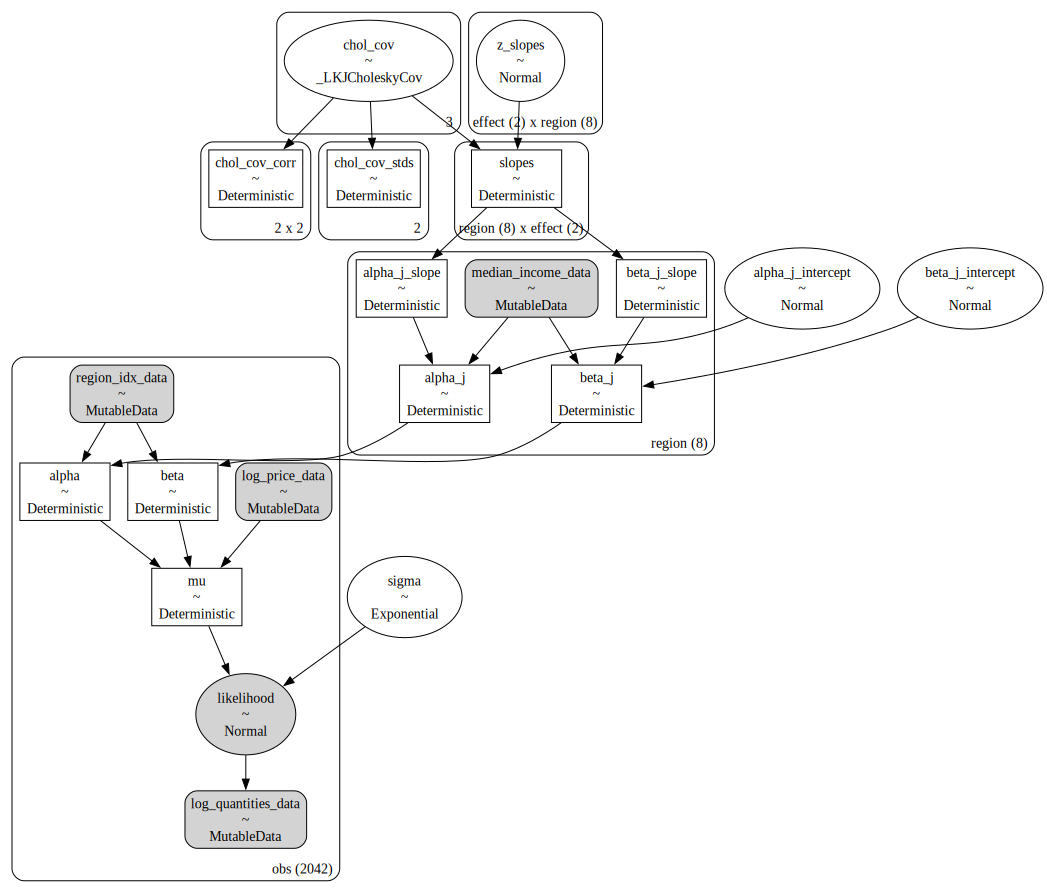

In [8]:
coords = {
    "effect": ["intercept", "slope"],
}

with pm.Model(coords=coords) as model_cov_red:
    # --- Data Containers ---

    model_cov_red.add_coord(name="region", values=region_red, mutable=True)
    model_cov_red.add_coord(name="obs", values=obs_red, mutable=True)

    region_idx_data = pm.Data(
        name="region_idx_data", value=region_idx_red, mutable=True, dims="obs"
    )
    median_income_data = pm.Data(
        name="median_income_data",
        value=median_income_red.to_numpy(),
        mutable=True,
        dims="region",
    )
    log_price_data = pm.Data(
        name="log_price_data", value=log_price_red, mutable=True, dims="obs"
    )
    log_quantities_data = pm.Data(
        name="log_quantities_data", value=log_quantities_red, mutable=True, dims="obs"
    )

    # --- Priors ---
    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)

    sd_dist = pm.HalfNormal.dist(sigma=0.02, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    z_slopes = pm.Normal(name="z_slopes", mu=0, sigma=1, dims=("effect", "region"))
    slopes = pm.Deterministic(
        name="slopes", var=pt.dot(chol, z_slopes).T, dims=("region", "effect")
    )

    # --- Parametrization ---
    alpha_j_slope = pm.Deterministic(
        name="alpha_j_slope", var=slopes[:, 0], dims="region"
    )

    beta_j_slope = pm.Deterministic(
        name="beta_j_slope", var=slopes[:, 1], dims="region"
    )

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=alpha_j_intercept + alpha_j_slope * median_income_data,
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=beta_j_intercept + beta_j_slope * median_income_data,
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx_data], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx_data], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price_data, dims="obs")

    # --- Likelihood ---
    pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=log_quantities_data, dims="obs"
    )

pm.model_to_graphviz(model=model_cov_red)

In [9]:
with model_cov_red:
    idata_cov_red = pm.sample(
        target_accept=0.9,
        draws=6_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_cov_red = pm.sample_posterior_predictive(
        trace=idata_cov_red, random_seed=rng
    )

Compiling...
Compilation time = 0:00:03.481173
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time = 0:00:30.260998
Transforming variables...
Transformation time = 0:00:02.294053
Sampling: [likelihood]


Text(0.5, 0.98, 'Covariance Multilevel Model (Red) - Trace')

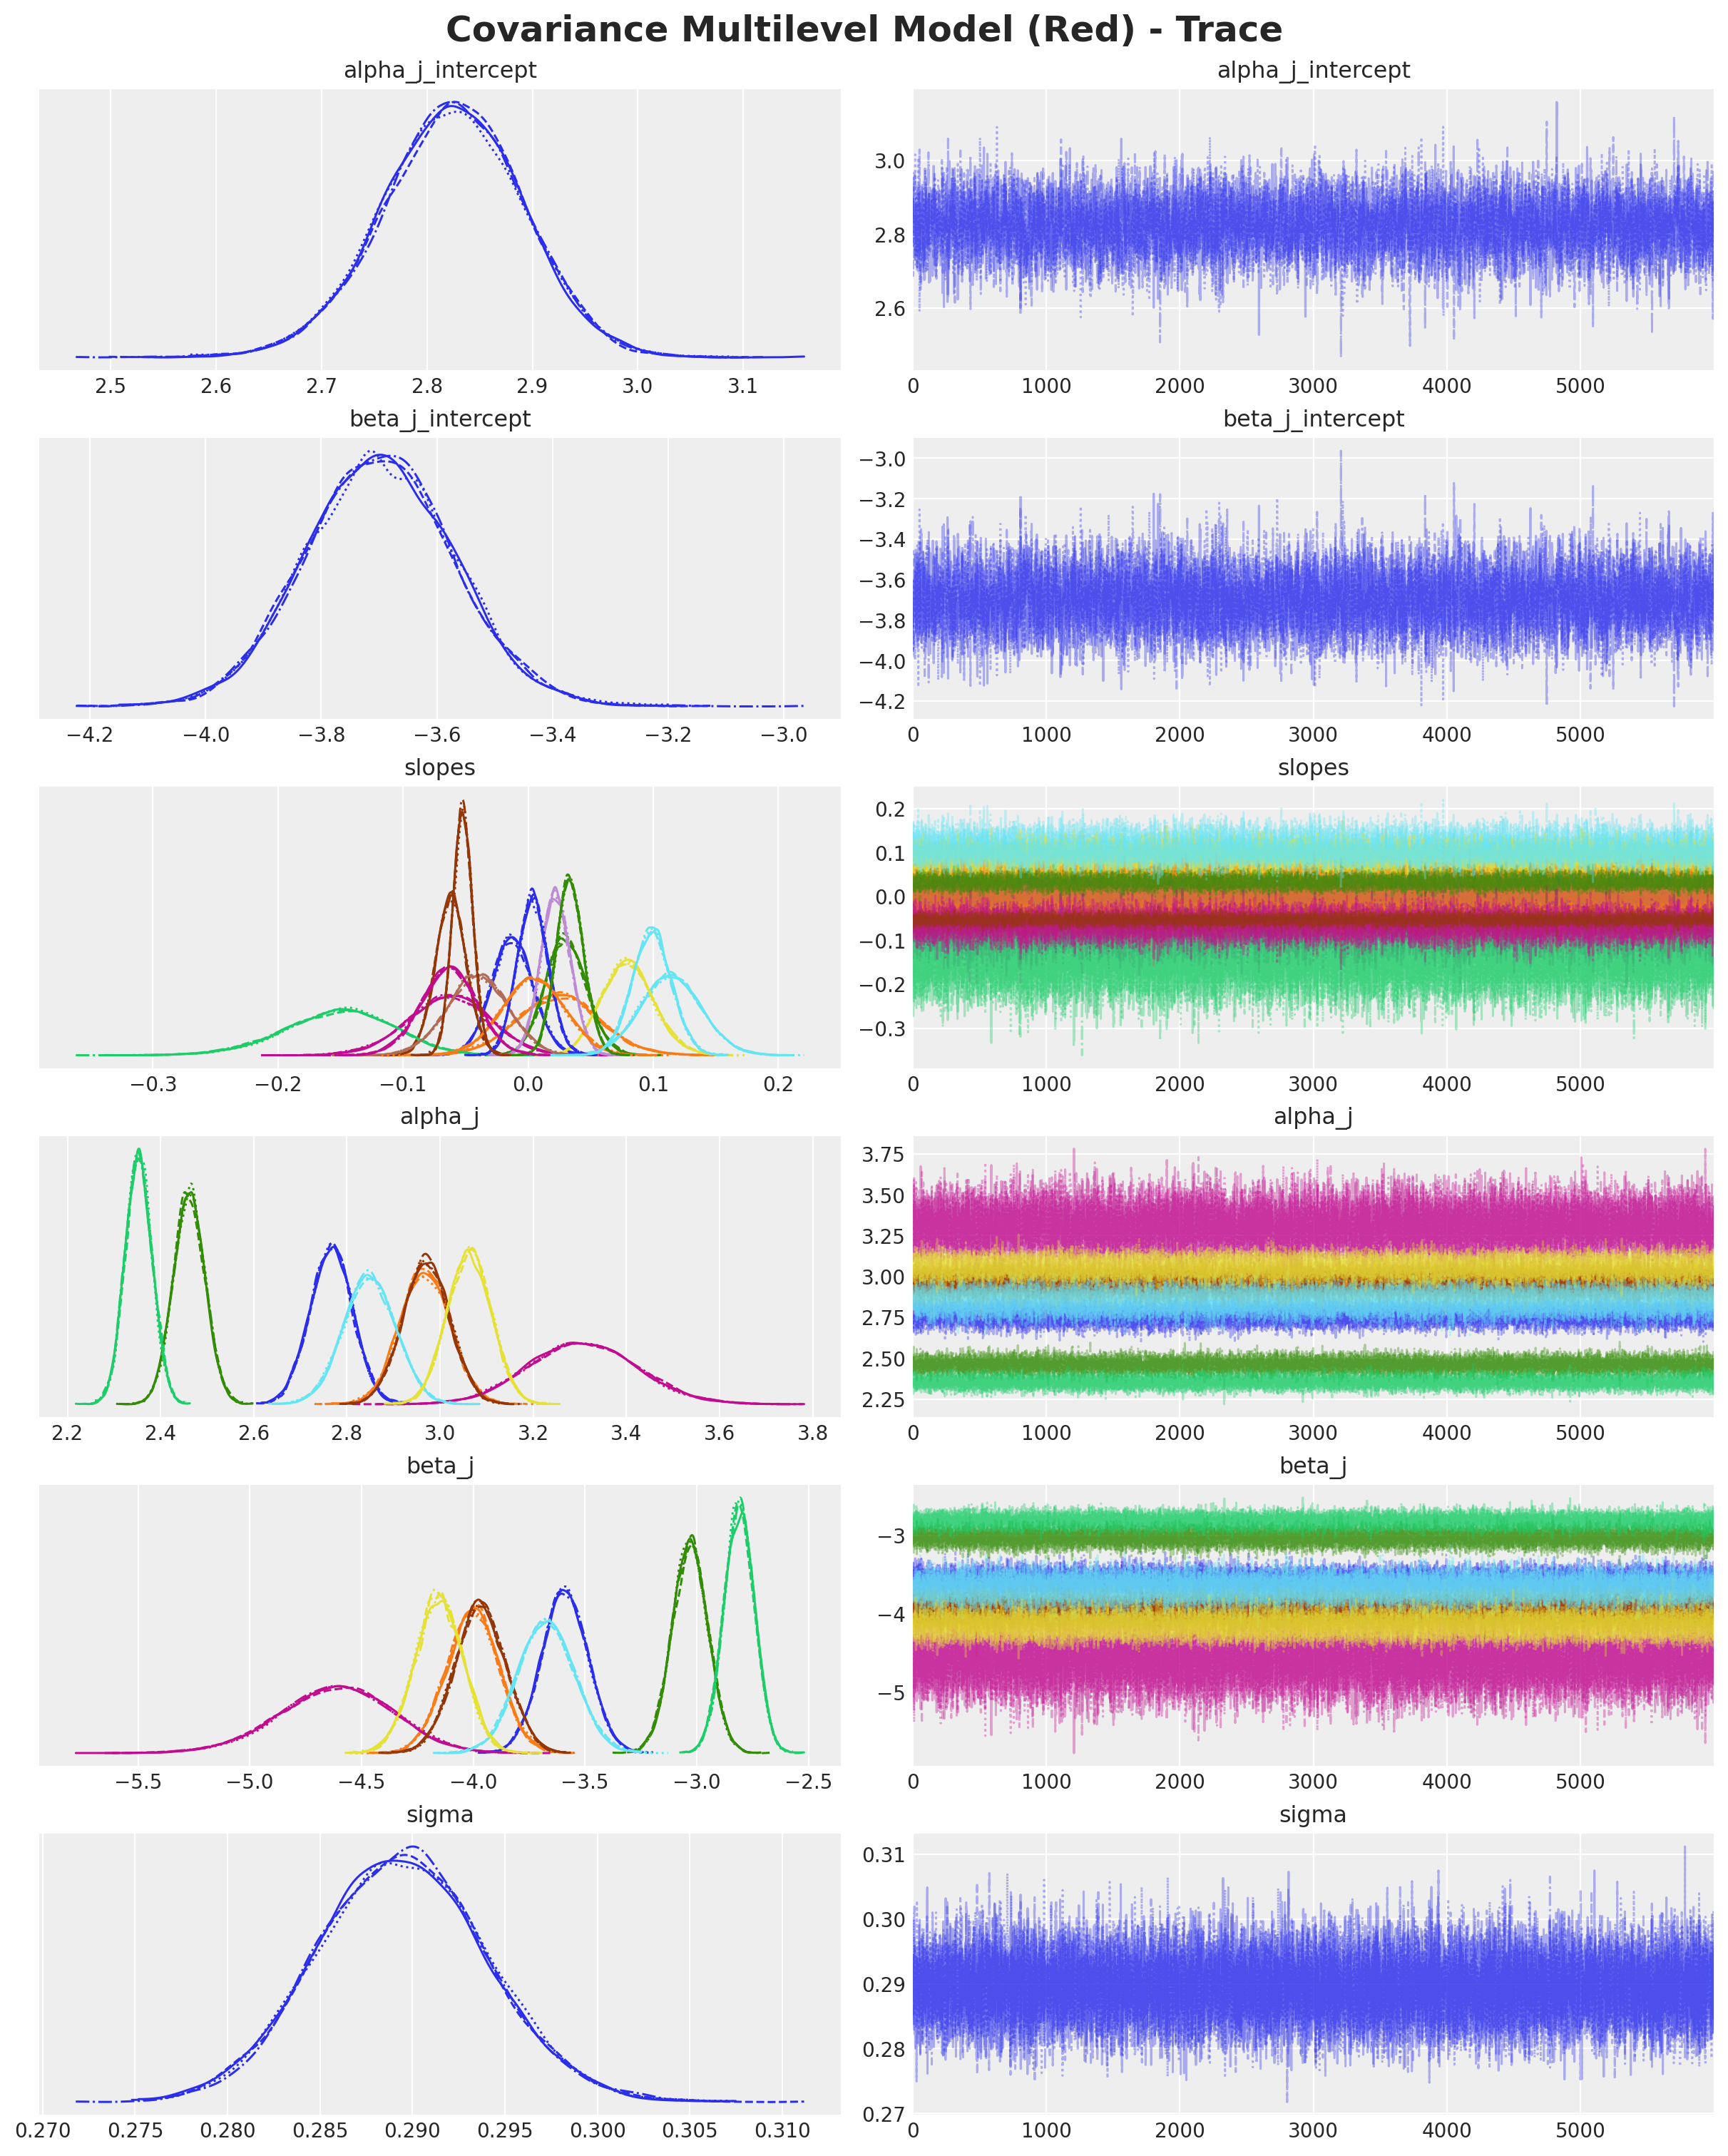

In [10]:
var_names = [
    "alpha_j_intercept",
    "beta_j_intercept",
    "slopes",
    "alpha_j",
    "beta_j",
    "sigma",
]


axes = az.plot_trace(
    data=idata_cov_red,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Covariance Multilevel Model (Red) - Trace", fontsize=18, fontweight="bold"
)

In [14]:
with model_cov_red:
    pm.set_data(
        new_data={
            "region_idx_data": region_idx,
            "median_income_data": median_income.to_numpy(),
            "log_price_data": log_price,
            "log_quantities_data": log_quantities,
        },
        coords={"region": region, "obs": obs},
    )
    posterior_predictive_cov = pm.sample_posterior_predictive(
        trace=idata_cov_red, var_names=["beta_j", "likelihood"], random_seed=rng
    )

Sampling: [likelihood, z_slopes]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Prices vs Quantities by Region - Covariance Multilevel Model')

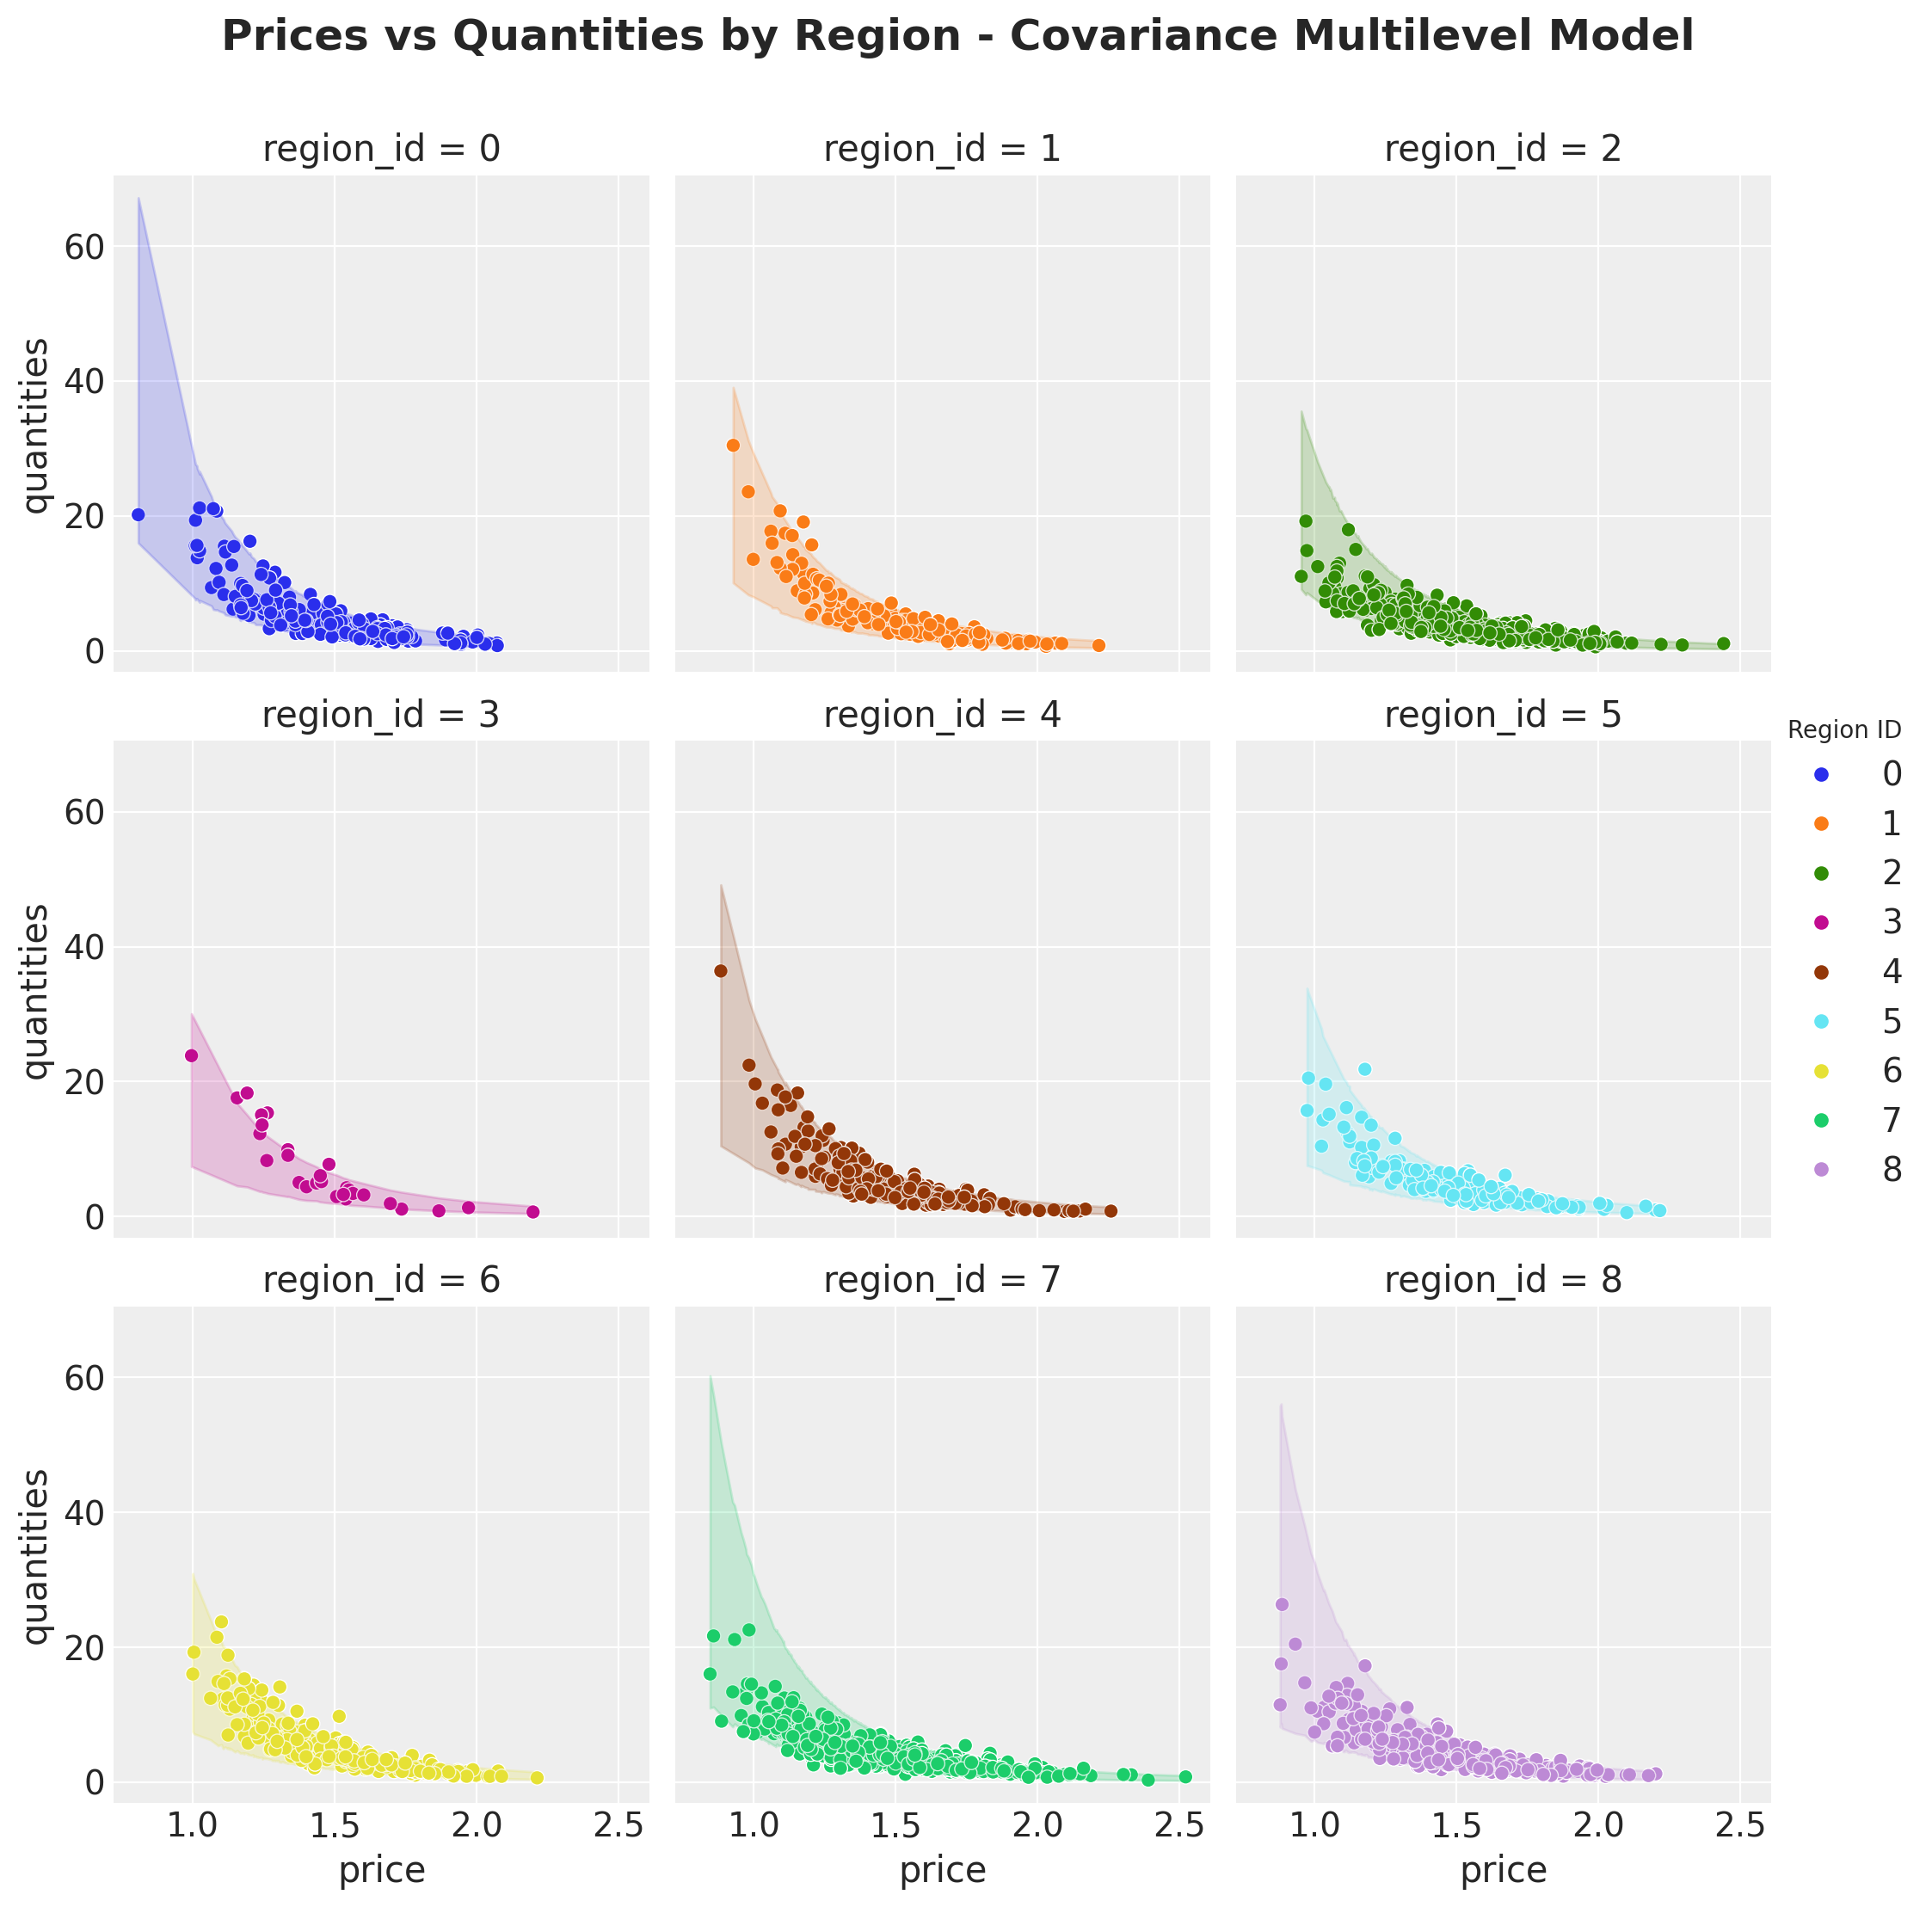

In [15]:
exp_likelihood_hdi = az.hdi(
    ary=np.exp(posterior_predictive_cov["posterior_predictive"]["likelihood"])
)["likelihood"]

g = sns.relplot(
    data=market_df.assign(region_id=lambda x: x["region_id"].astype(str)),
    x="price",
    y="quantities",
    kind="scatter",
    col="region_id",
    col_wrap=3,
    hue="region_id",
    height=3.5,
    aspect=1,
    facet_kws={"sharex": True, "sharey": True},
)

axes = g.axes.flatten()

for i, region_to_plot in enumerate(region):
    ax = axes[i]

    price_region = price[region_idx == region_to_plot]
    price_region_argsort = np.argsort(price_region)

    ax.fill_between(
        x=price_region[price_region_argsort],
        y1=exp_likelihood_hdi[region_idx == region_to_plot][price_region_argsort, 0],
        y2=exp_likelihood_hdi[region_idx == region_to_plot][price_region_argsort, 1],
        color=f"C{i}",
        alpha=0.2,
    )

legend = g.legend
legend.set_title(title="Region ID", prop={"size": 10})
g.fig.suptitle(
    "Prices vs Quantities by Region - Covariance Multilevel Model",
    y=1.05,
    fontsize=18,
    fontweight="bold",
)

Text(0.5, 1.0, 'Base Model')

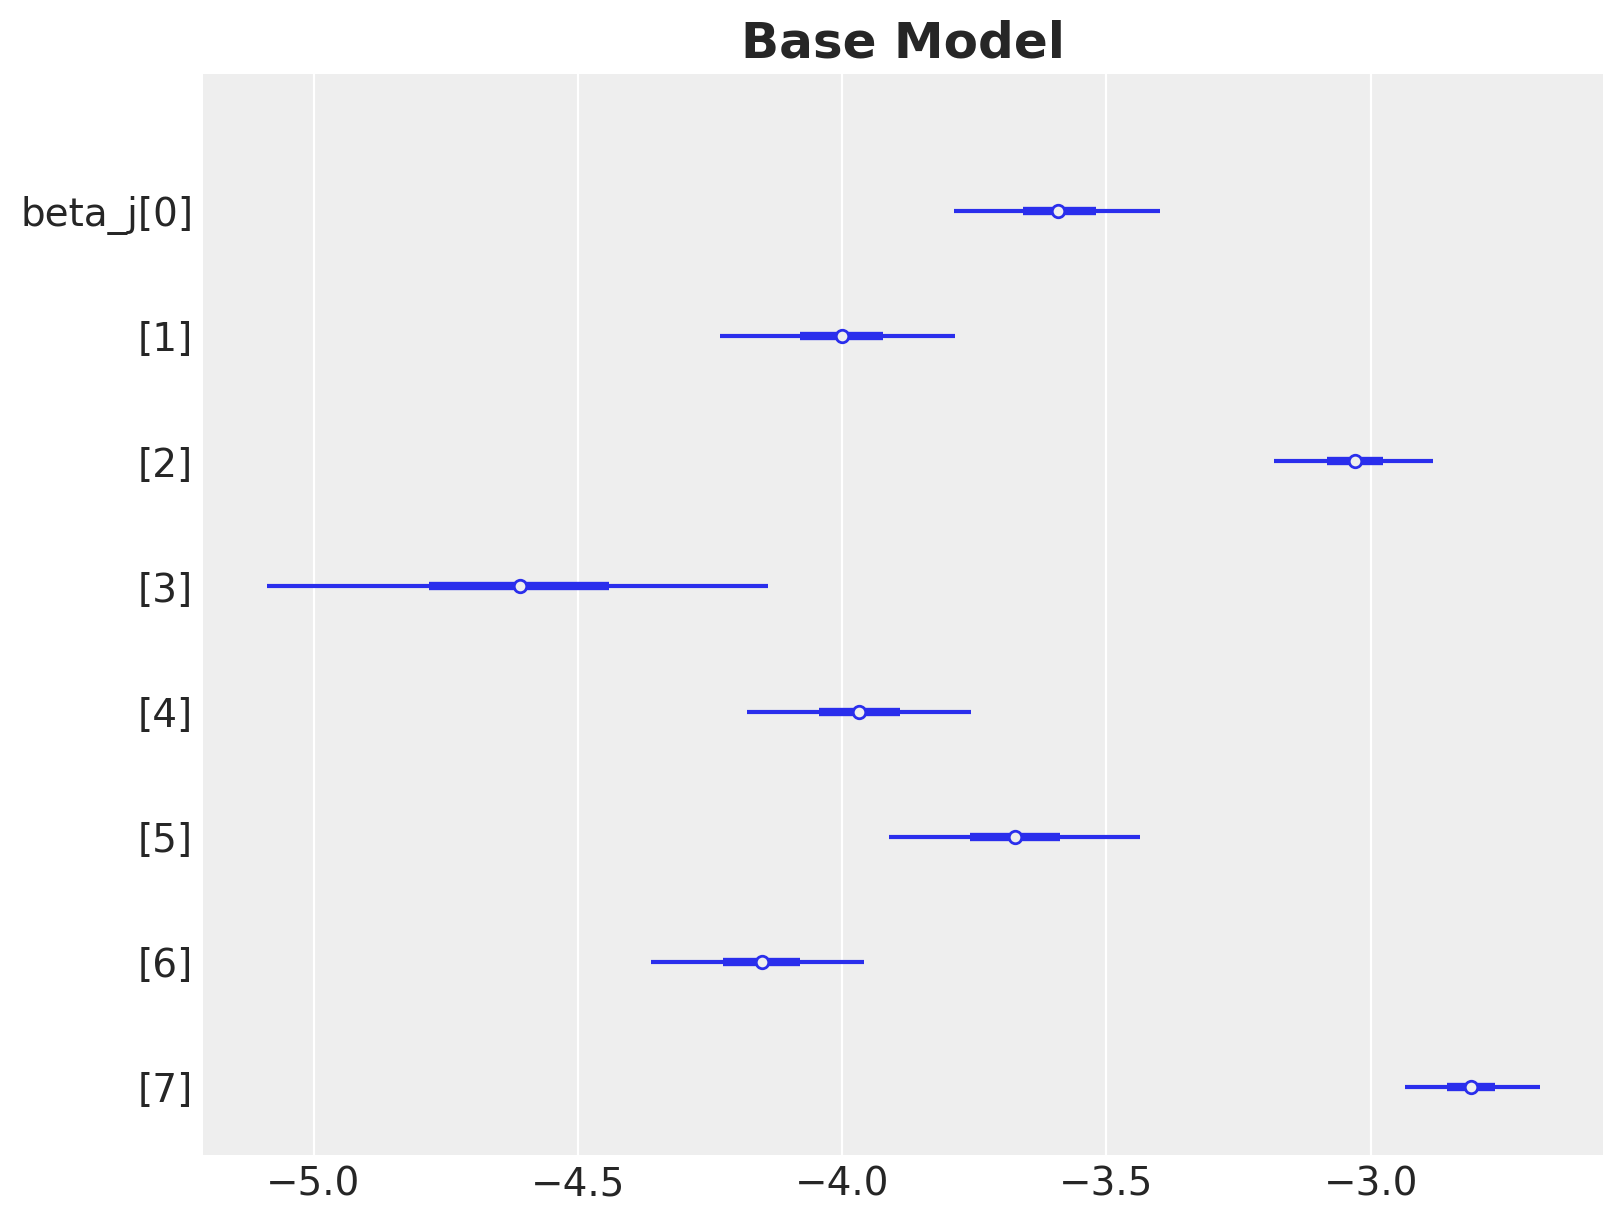

In [30]:
ax, *_ = az.plot_forest(
    data=idata_cov_red,
    var_names=["beta_j"],
    combined=True,
    figsize=(8, 6),
)
ax.set_title(label="Base Model", fontsize=18, fontweight="bold")

Text(0.5, 1.0, 'Base Model')

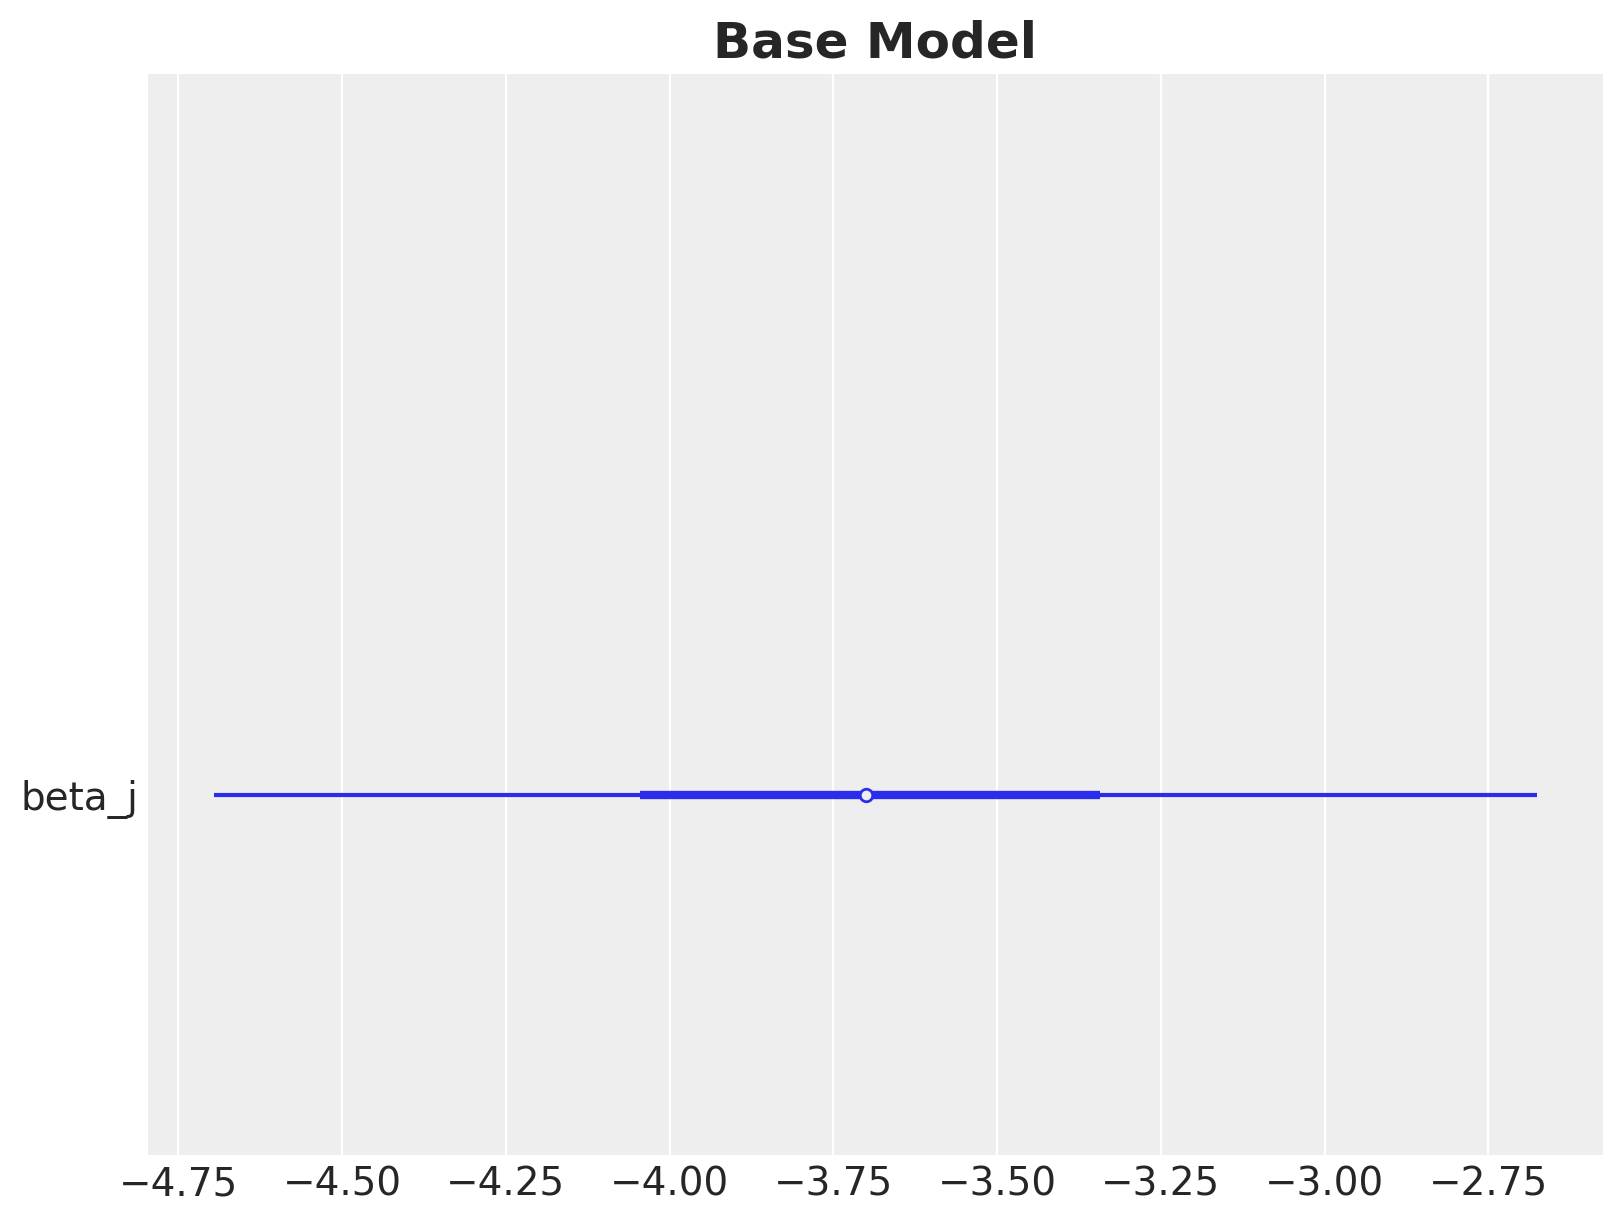

In [32]:
ax, *_ = az.plot_forest(
    data=posterior_predictive_cov["posterior_predictive"].sel(region=region_id_out),
    var_names=["beta_j"],
    combined=True,
    figsize=(8, 6),
)
ax.set_title(label="Base Model", fontsize=18, fontweight="bold")